In [3]:
%%capture
!pip install pyspark

## Projet Spark : Analyse de données d'un service de streaming musical


#### Context du projet  :
On considère un dataset d'un service de streaming musical à explorer.

L'objectif est de tirer des informations utiles sur l'utilisation de la plateforme, le comportement des utilisateurs et les tendances d'écoute, en utilisant les concepts fondamentaux de Spark, pour manipuler et analyser des données à grande échelle.

#### Dataset :
Le dataset utilisé, "spotify_logs.json", contient des logs / journaux d'événements d'une application de streaming musical. Chaque entrée du dataset correspond à une interaction de l'utilisateur avec le service de streaming. Les attributs incluent des informations sur l'utilisateur, telles que son ID, son genre, le niveau d'abonnement, ainsi que des détails sur les événements comme la chanson écoutée, la page visitée, l'heure de l'événement, etc.

#### Objectif du Projet :
Le projet consiste à réaliser une série d'analyses et de calculs sur ces données en utilisant Apache Spark


Ressource utile:
https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/index.html

## Travail demandé et Livrables :

- Ecrire le code Pyspark qui permet de répondre aux questions ci dessous.
- Rendre votre notebook avec la trace d'exécution de vos cellules.



In [4]:
#Import des libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when,countDistinct, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, StringType


import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##  **Charger les données**

- Importer toutes autres libraries dont vous pourriez avoir besoin
- Instancier une session Spark
- Lire le dataset "spotify_logs.json"
- afficher le schéma des données


In [6]:
# create entry points to spark
try:
    sc.stop()
except:
    pass

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

spark = SparkSession \
        .builder \
        .appName("Spark SQL") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Spark SQL>

In [8]:
# import dataset
path='spotify_logs.json'
df = spark.read.json(path)
df.show(5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       Showaddywaddy|Logged In|  Kenneth|     M|          112| Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|
|          Lily Allen|Logged In|Elizabeth|     F|            7|    Chase|195.23873| free|Shreveport-Bossie...|   PUT

In [10]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## **Questions: Exploration et Analyse de données**
2. Combien de logs sont présents dans le dataset ?
3. Combien d'artistes sont présents dans le dataset?
4. Trouver le nombre d'utilisateurs inscrits dans le dataset ?
5. Quels sont les types de niveau d'abonnement (level) disponibles dans le dataset ?
6. Quelles sont les pages disponibles dans le dataset et combien de fois chacune d'elles a-t-elle été visitée ?

7. Combien de logs a enregistré l'utilisateur d'id: 1138,

   Afficher les 5 premiers et les 5 derniers logs de cet utilisateur, que remarquez vous?
8. Combien de pages l'utilisateur avec l'id "" (empty string) n'a-t-il PAS visitée, afficher les .
9. De quel type d'utilisateurs s'agit il à votre avis?
10. Combien d'utilisateurs de chaque genre sont présents dans le dataset ?
11. Visualiser la répartition, Y a-t-il une différence significative entre le nombre d'utilisateurs de chaque genre ?
12. Quel est l'artiste le plus écouté dans le dataset et combien de fois ses chansons ont-elles été jouées ?
13. Combien de chansons différentes ont été jouées dans l'ensemble des logs ?

14. Visualiser le nombre de chansons jouées par heure,  À quelle heure de la journée les utilisateurs écoutent-ils le plus de chansons ?
15. Trouver les utilisateurs qui ont fait des upgrade et downgrade de leur abonnement?

16. Créer une vue temporaire répondre avec des requêtes SQL aux questions suivantes:

 a- Afficher les 3 premiers logs de l'utilisateur d'id 1046

 b- Trouver les pages que les utilisateurs ayant empty userID ont visité

 c- Combien de chansons ont été jouées par l'artiste le plus joué
17. Proposer un axe d'analyse de votre choix ?


In [9]:
#Combien de logs sont présents dans le dataset ?
df.count()

10000

In [11]:
#Combien d'artistes sont présents dans le dataset?
df.select('artist').distinct().count()

3618

In [12]:
#Trouver le nombre d'utilisateurs inscrits dans le dataset ?
df.select('userId').distinct().count()

964

In [13]:
#Quels sont les types de niveau d'abonnement (level) disponibles dans le dataset ?
df.select('level').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [16]:
#Quelles sont les pages disponibles dans le dataset et combien de fois chacune d'elles a-t-elle été visitée ?
df.groupBy('page').count().show()

+----------------+-----+
|            page|count|
+----------------+-----+
|Submit Downgrade|    1|
|            Home| 1126|
|       Downgrade|   75|
|          Logout|  100|
|   Save Settings|   11|
|           About|   43|
|        Settings|   59|
|           Login|  126|
|        NextSong| 8347|
|            Help|   58|
|         Upgrade|   32|
|           Error|   12|
|  Submit Upgrade|   10|
+----------------+-----+



In [19]:
#Combien de logs a enregistré l'utilisateur d'id: 1138
df.filter(df.userId == 1138).count()

68

In [20]:
#Afficher les 5 premiers et les 5 derniers logs de cet utilisateur, que remarquez vous?
df.filter(df.userId == 1138).sort(desc('ts')).show(5)
df.filter(df.userId == 1138).sort(asc('ts')).show(5)

+--------------------+---------+---------+------+-------------+--------+--------+-----+--------------------+------+----------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|  length|level|            location|method|            page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+--------+-----+--------------------+------+----------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|FrÃÂ©meaux & Ass...|Logged In|    Kelly|     F|            0|  Newton|28.96934| free|Houston-The Woodl...|   PUT|        NextSong|1513283366284|     7011|Grenouilles Manti...|   200|1513833144284|Mozilla/5.0 (Wind...|  1138|
|                NULL|Logged In|    Kelly|     F|            0|  Newton|    NULL| free|Houst

In [61]:
#Combien de pages l'utilisateur avec l'id "" (empty string) n'a-t-il PAS visitée, afficher les
all_pages = df.select("page").distinct()
visited_pages = df.filter(df.userId == "").groupBy("page").count()
never_visited_pages = all_pages.join(visited_pages, on="page", how="leftanti")
never_visited_pages.show(truncate=False)

+----------------+
|page            |
+----------------+
|Submit Downgrade|
|Downgrade       |
|Logout          |
|Save Settings   |
|Settings        |
|NextSong        |
|Upgrade         |
|Error           |
|Submit Upgrade  |
+----------------+



In [23]:
#De quel type d'utilisateurs s'agit il à votre avis?
df.filter(df.userId == '').groupBy('level').count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|  193|
| paid|  143|
+-----+-----+



In [55]:
#Combien d'utilisateurs de chaque genre sont présents dans le dataset ?
tmp=df.dropDuplicates(['userId']).groupBy('gender').count()
tmp.show()

+------+-----+
|gender|count|
+------+-----+
|     F|  462|
|  NULL|    1|
|     M|  501|
+------+-----+



<Axes: xlabel='gender'>

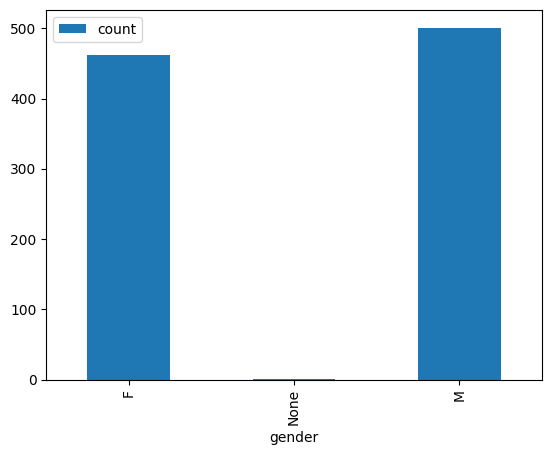

In [57]:
#Visualiser la répartition, Y a-t-il une différence significative entre le nombre d'utilisateurs de chaque genre ?
tmp.toPandas().plot(kind='bar', x='gender', y='count')

In [47]:
#Quel est l'artiste le plus écouté dans le dataset et combien de fois ses chansons ont-elles été jouées ?
df.filter(df.artist!="NULL").groupBy('artist').count().sort(desc('count')).show(1)

+--------+-----+
|  artist|count|
+--------+-----+
|Coldplay|   83|
+--------+-----+
only showing top 1 row



In [49]:
#Combien de chansons différentes ont été jouées dans l'ensemble des logs ?
df.select('song').distinct().count()

6126

In [71]:
#Visualiser le nombre de chansons jouées par heure, À quelle heure de la journée les utilisateurs écoutent-ils le plus de chansons ?
from pyspark.sql.functions import from_unixtime, hour, count
songs_by_hour = df.filter(df.song != "NULL") \
                  .withColumn("timestamp", from_unixtime(df.ts / 1000)) \
                  .withColumn("hour", hour("timestamp")) \
                  .groupBy("hour") \
                  .agg(count("*").alias("song_count")) \
                  .orderBy("hour")

songs_by_hour.show()

+----+----------+
|hour|song_count|
+----+----------+
|   0|       456|
|   1|       454|
|   2|       382|
|   3|       302|
|   4|       352|
|   5|       276|
|   6|       348|
|   7|       358|
|   8|       375|
|   9|       249|
|  10|       216|
|  11|       228|
|  12|       251|
|  13|       339|
|  14|       462|
|  15|       479|
|  16|       484|
|  17|       430|
|  18|       362|
|  19|       295|
+----+----------+
only showing top 20 rows



<Axes: xlabel='hour'>

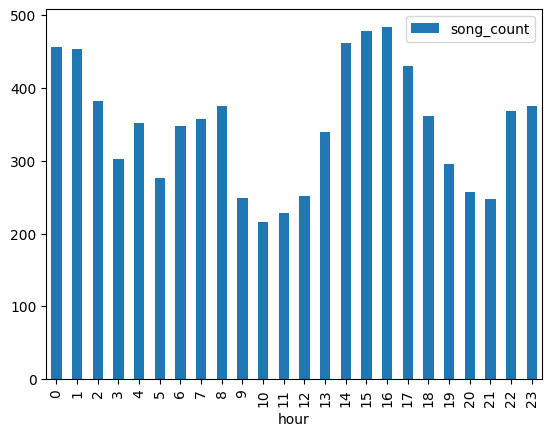

In [72]:
#plot songs_by_hour
songs_by_hour.toPandas().plot(kind='bar', x='hour', y='song_count')

In [82]:
#Trouver les utilisateurs qui ont fait des upgrade et downgrade de leur abonnement?
df.filter((df.page == 'Submit Upgrade') | (df.page == 'Submit Downgrade')).select('firstName','lastName','Page').distinct().show()

+---------+---------+----------------+
|firstName| lastName|            Page|
+---------+---------+----------------+
|     Jack|    Kelly|  Submit Upgrade|
|    Jewel|    Clark|  Submit Upgrade|
| Isabella|   Davies|  Submit Upgrade|
|   London|Dominguez|  Submit Upgrade|
| Jonathan|  Webster|  Submit Upgrade|
|   Dreden|Rodriguez|  Submit Upgrade|
|   Melody| Williams|  Submit Upgrade|
|   Ashton|   Nelson|  Submit Upgrade|
|     Lucy|   Ramsey|  Submit Upgrade|
|  Ryleigh| Melendez|  Submit Upgrade|
|    Kelly|   Newton|Submit Downgrade|
+---------+---------+----------------+



In [77]:
#Créer une vue temporaire
df.createOrReplaceTempView("logs")

In [78]:
#Afficher les 3 premiers logs de l'utilisateur d'id 1046
spark.sql("""
    SELECT *
    FROM logs
    WHERE userId = 1046
    LIMIT 3
""").show()

+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|Showaddywaddy|Logged In|  Kenneth|     M|          112|Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|
|Darius Rucker|Logged In|  Kenneth|     M|          113|Matthews|206.00118| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|  Be W

In [79]:
#Trouver les pages que les utilisateurs ayant empty userID ont visité
spark.sql("""
    SELECT page, COUNT(*) as count
    FROM logs
    WHERE userId = ''
    GROUP BY page
""").show()

+-----+-----+
| page|count|
+-----+-----+
| Home|  187|
|About|   15|
|Login|  126|
| Help|    8|
+-----+-----+



In [80]:
#Combien de chansons ont été jouées par l'artiste le plus joué
spark.sql("""
    SELECT artist, COUNT(*) as count
    FROM logs
    WHERE artist != 'NULL'
    GROUP BY artist
    ORDER BY count DESC
    LIMIT 1
""").show()

+--------+-----+
|  artist|count|
+--------+-----+
|Coldplay|   83|
+--------+-----+



+------+-------------------+
|userId|   average_duration|
+------+-------------------+
|  1109|        0.878693425|
|  2818|         0.65577751|
|  2680|         0.62362077|
|  2772|         0.57346567|
|  2488|         0.51213016|
|  1872|0.49713587000000004|
|  1272|0.49657859333333326|
|  2399|        0.491166895|
|   625|         0.48605995|
|  2720|         0.47950322|
|  2446|         0.47932036|
|   797|0.46560608000000003|
|   780|0.46505750999999995|
|  1398| 0.4593963971428572|
|  1809|0.45157832499999995|
|  2623|0.44813015999999994|
|   608|         0.44742485|
|  2997|         0.44557016|
|  1150|         0.44110322|
|  1849|0.44071138000000004|
+------+-------------------+
only showing top 20 rows

+-----+-------------------+
|level|   average_duration|
+-----+-------------------+
| free|0.24998360126310784|
| paid|0.24953620725396095|
+-----+-------------------+



<Axes: xlabel='level'>

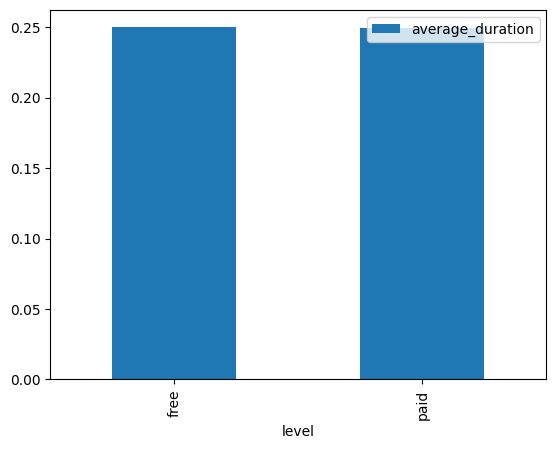

In [81]:
# Analyse de la durée d'écoute des chansons
df_with_duration = df.withColumn("duration", df["length"] / 1000)

# Calculer la durée moyenne d'écoute par utilisateur
average_listening_time = df_with_duration.groupBy("userId").agg(avg("duration").alias("average_duration"))

# Afficher les utilisateurs ayant la durée d'écoute moyenne la plus élevée
average_listening_time.orderBy(desc("average_duration")).show()

# Explorer la relation entre la durée d'écoute et le niveau d'abonnement
average_listening_time_by_level = df_with_duration.groupBy("level").agg(avg("duration").alias("average_duration"))

# Afficher la durée d'écoute moyenne par niveau d'abonnement
average_listening_time_by_level.show()

# Visualiser la relation entre la durée d'écoute et le niveau d'abonnement
average_listening_time_by_level.toPandas().plot(kind='bar', x='level', y='average_duration')
